In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
from glob import glob
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import keras
from keras import layers

import tensorflow as tf

In [2]:
import requests
import zipfile
import io

# URL of the dataset zip file
url = "https://huggingface.co/datasets/geekyrakshit/LoL-Dataset/resolve/main/lol_dataset.zip"

# Send a GET request to the URL
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Read the content of the response
    zip_content = response.content
    
    # Write the content to a file
    with open('lol_dataset.zip', 'wb') as f:
        f.write(zip_content)
    
    # Extract the zip file
    with zipfile.ZipFile('lol_dataset.zip', 'r') as zip_ref:
        zip_ref.extractall('.')
    
    # Remove the zip file after extraction
    import os
    os.remove('lol_dataset.zip')
    
    print("Dataset downloaded and extracted successfully.")
else:
    print(f"Failed to download dataset. Status code: {response.status_code}")


Dataset downloaded and extracted successfully.


In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 16
MAX_TRAIN_IMAGES = 400


def load_data(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = image / 255.0
    return image


def data_generator(low_light_images):
    dataset = tf.data.Dataset.from_tensor_slices((low_light_images))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_low_light_images = sorted(glob("./lol_dataset/our485/low/*"))[:MAX_TRAIN_IMAGES]
val_low_light_images = sorted(glob("./lol_dataset/our485/low/*"))[MAX_TRAIN_IMAGES:]
test_low_light_images = sorted(glob("./lol_dataset/eval15/low/*"))


train_dataset = data_generator(train_low_light_images)
val_dataset = data_generator(val_low_light_images)

print("Train Dataset:", train_dataset)
print("Validation Dataset:", val_dataset)

Train Dataset: <_BatchDataset element_spec=TensorSpec(shape=(16, 256, 256, 3), dtype=tf.float32, name=None)>
Validation Dataset: <_BatchDataset element_spec=TensorSpec(shape=(16, 256, 256, 3), dtype=tf.float32, name=None)>


In [4]:
def build_dce_net():
    input_img = keras.Input(shape=[None, None, 3])
    conv1 = layers.Conv2D(
        64, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(input_img)
    conv2 = layers.Conv2D(
        64, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv1)
    conv3 = layers.Conv2D(
        64, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv2)
    conv4 = layers.Conv2D(
        64, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv3)
    int_con1 = layers.Concatenate(axis=-1)([conv4, conv3])
    conv5 = layers.Conv2D(
        64, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(int_con1)
    int_con2 = layers.Concatenate(axis=-1)([conv5, conv2])
    conv6 = layers.Conv2D(
        64, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(int_con2)
    int_con3 = layers.Concatenate(axis=-1)([conv6, conv1])
    x_r = layers.Conv2D(24, (3, 3), strides=(1, 1), activation="tanh", padding="same")(
        int_con3
    )
    return keras.Model(inputs=input_img, outputs=x_r)

In [5]:
def color_constancy_loss(x):
    mean_rgb = tf.reduce_mean(x, axis=(1, 2), keepdims=True)
    mr, mg, mb = (
        mean_rgb[:, :, :, 0],
        mean_rgb[:, :, :, 1],
        mean_rgb[:, :, :, 2],
    )
    d_rg = tf.square(mr - mg)
    d_rb = tf.square(mr - mb)
    d_gb = tf.square(mb - mg)
    return tf.sqrt(tf.square(d_rg) + tf.square(d_rb) + tf.square(d_gb))

In [6]:
def exposure_loss(x, mean_val=0.6):
    x = tf.reduce_mean(x, axis=3, keepdims=True)
    mean = tf.nn.avg_pool2d(x, ksize=16, strides=16, padding="VALID")
    return tf.reduce_mean(tf.square(mean - mean_val))

In [7]:
def illumination_smoothness_loss(x):
    batch_size = tf.shape(x)[0]
    h_x = tf.shape(x)[1]
    w_x = tf.shape(x)[2]
    count_h = (tf.shape(x)[2] - 1) * tf.shape(x)[3]
    count_w = tf.shape(x)[2] * (tf.shape(x)[3] - 1)
    h_tv = tf.reduce_sum(tf.square((x[:, 1:, :, :] - x[:, : h_x - 1, :, :])))
    w_tv = tf.reduce_sum(tf.square((x[:, :, 1:, :] - x[:, :, : w_x - 1, :])))
    batch_size = tf.cast(batch_size, dtype=tf.float32)
    count_h = tf.cast(count_h, dtype=tf.float32)
    count_w = tf.cast(count_w, dtype=tf.float32)
    return 2 * (h_tv / count_h + w_tv / count_w) / batch_size

In [8]:
class SpatialConsistencyLoss(keras.losses.Loss):
    def __init__(self, **kwargs):
        super().__init__(reduction="none")

        self.left_kernel = tf.constant(
            [[[[0, 0, 0]], [[-1, 1, 0]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.right_kernel = tf.constant(
            [[[[0, 0, 0]], [[0, 1, -1]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.up_kernel = tf.constant(
            [[[[0, -1, 0]], [[0, 1, 0]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.down_kernel = tf.constant(
            [[[[0, 0, 0]], [[0, 1, 0]], [[0, -1, 0]]]], dtype=tf.float32
        )

    def call(self, y_true, y_pred):
        original_mean = tf.reduce_mean(y_true, 3, keepdims=True)
        enhanced_mean = tf.reduce_mean(y_pred, 3, keepdims=True)
        original_pool = tf.nn.avg_pool2d(
            original_mean, ksize=4, strides=4, padding="VALID"
        )
        enhanced_pool = tf.nn.avg_pool2d(
            enhanced_mean, ksize=4, strides=4, padding="VALID"
        )

        d_original_left = tf.nn.conv2d(
            original_pool,
            self.left_kernel,
            strides=[1, 1, 1, 1],
            padding="SAME",
        )
        d_original_right = tf.nn.conv2d(
            original_pool,
            self.right_kernel,
            strides=[1, 1, 1, 1],
            padding="SAME",
        )
        d_original_up = tf.nn.conv2d(
            original_pool, self.up_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_original_down = tf.nn.conv2d(
            original_pool,
            self.down_kernel,
            strides=[1, 1, 1, 1],
            padding="SAME",
        )

        d_enhanced_left = tf.nn.conv2d(
            enhanced_pool,
            self.left_kernel,
            strides=[1, 1, 1, 1],
            padding="SAME",
        )
        d_enhanced_right = tf.nn.conv2d(
            enhanced_pool,
            self.right_kernel,
            strides=[1, 1, 1, 1],
            padding="SAME",
        )
        d_enhanced_up = tf.nn.conv2d(
            enhanced_pool, self.up_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_enhanced_down = tf.nn.conv2d(
            enhanced_pool,
            self.down_kernel,
            strides=[1, 1, 1, 1],
            padding="SAME",
        )

        d_left = tf.square(d_original_left - d_enhanced_left)
        d_right = tf.square(d_original_right - d_enhanced_right)
        d_up = tf.square(d_original_up - d_enhanced_up)
        d_down = tf.square(d_original_down - d_enhanced_down)
        return d_left + d_right + d_up + d_down

In [9]:
class ZeroDCE(keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.dce_model = build_dce_net()

    def compile(self, learning_rate, **kwargs):
        super().compile(**kwargs)
        self.optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        self.spatial_constancy_loss = SpatialConsistencyLoss(reduction="none")
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.illumination_smoothness_loss_tracker = keras.metrics.Mean(
            name="illumination_smoothness_loss"
        )
        self.spatial_constancy_loss_tracker = keras.metrics.Mean(
            name="spatial_constancy_loss"
        )
        self.color_constancy_loss_tracker = keras.metrics.Mean(
            name="color_constancy_loss"
        )
        self.exposure_loss_tracker = keras.metrics.Mean(name="exposure_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.illumination_smoothness_loss_tracker,
            self.spatial_constancy_loss_tracker,
            self.color_constancy_loss_tracker,
            self.exposure_loss_tracker,
        ]

    def get_enhanced_image(self, data, output):
        r1 = output[:, :, :, :3]
        r2 = output[:, :, :, 3:6]
        r3 = output[:, :, :, 6:9]
        r4 = output[:, :, :, 9:12]
        r5 = output[:, :, :, 12:15]
        r6 = output[:, :, :, 15:18]
        r7 = output[:, :, :, 18:21]
        r8 = output[:, :, :, 21:24]
        x = data + r1 * (tf.square(data) - data)
        x = x + r2 * (tf.square(x) - x)
        x = x + r3 * (tf.square(x) - x)
        enhanced_image = x + r4 * (tf.square(x) - x)
        x = enhanced_image + r5 * (tf.square(enhanced_image) - enhanced_image)
        x = x + r6 * (tf.square(x) - x)
        x = x + r7 * (tf.square(x) - x)
        enhanced_image = x + r8 * (tf.square(x) - x)
        return enhanced_image

    def call(self, data):
        dce_net_output = self.dce_model(data)
        return self.get_enhanced_image(data, dce_net_output)

    def compute_losses(self, data, output):
        enhanced_image = self.get_enhanced_image(data, output)
        loss_illumination = 200 * illumination_smoothness_loss(output)
        loss_spatial_constancy = tf.reduce_mean(
            self.spatial_constancy_loss(enhanced_image, data)
        )
        loss_color_constancy = 5 * tf.reduce_mean(color_constancy_loss(enhanced_image))
        loss_exposure = 10 * tf.reduce_mean(exposure_loss(enhanced_image))
        total_loss = (
            loss_illumination
            + loss_spatial_constancy
            + loss_color_constancy
            + loss_exposure
        )

        return {
            "total_loss": total_loss,
            "illumination_smoothness_loss": loss_illumination,
            "spatial_constancy_loss": loss_spatial_constancy,
            "color_constancy_loss": loss_color_constancy,
            "exposure_loss": loss_exposure,
        }

    def train_step(self, data):
        with tf.GradientTape() as tape:
            output = self.dce_model(data)
            losses = self.compute_losses(data, output)

        gradients = tape.gradient(
            losses["total_loss"], self.dce_model.trainable_weights
        )
        self.optimizer.apply_gradients(zip(gradients, self.dce_model.trainable_weights))

        self.total_loss_tracker.update_state(losses["total_loss"])
        self.illumination_smoothness_loss_tracker.update_state(
            losses["illumination_smoothness_loss"]
        )
        self.spatial_constancy_loss_tracker.update_state(
            losses["spatial_constancy_loss"]
        )
        self.color_constancy_loss_tracker.update_state(losses["color_constancy_loss"])
        self.exposure_loss_tracker.update_state(losses["exposure_loss"])

        return {metric.name: metric.result() for metric in self.metrics}

    def test_step(self, data):
        output = self.dce_model(data)
        losses = self.compute_losses(data, output)

        self.total_loss_tracker.update_state(losses["total_loss"])
        self.illumination_smoothness_loss_tracker.update_state(
            losses["illumination_smoothness_loss"]
        )
        self.spatial_constancy_loss_tracker.update_state(
            losses["spatial_constancy_loss"]
        )
        self.color_constancy_loss_tracker.update_state(losses["color_constancy_loss"])
        self.exposure_loss_tracker.update_state(losses["exposure_loss"])

        return {metric.name: metric.result() for metric in self.metrics}

    def save_weights(self, filepath, overwrite=True, save_format=None, options=None):
        """While saving the weights, we simply save the weights of the DCE-Net"""
        self.dce_model.save_weights(
            filepath,
            overwrite=overwrite,
            save_format=save_format,
            options=options,
        )

    def load_weights(self, filepath, by_name=False, skip_mismatch=False, options=None):
        """While loading the weights, we simply load the weights of the DCE-Net"""
        self.dce_model.load_weights(
            filepath=filepath,
            by_name=by_name,
            skip_mismatch=skip_mismatch,
            options=options,
        )

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 465s 19s/step - color_constancy_loss: 0.0040 - exposure_loss: 2.9888 - illumination_smoothness_loss: 1.0647 - spatial_constancy_loss: 9.8043e-06 - total_loss: 4.0574 - val_color_constancy_loss: 0.0024 - val_exposure_loss: 2.9384 - val_illumination_smoothness_loss: 1.1036 - val_spatial_constancy_loss: 2.3126e-05 - val_total_loss: 4.0444
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 420s 17s/step - color_constancy_loss: 0.0035 - exposure_loss: 2.9715 - illumination_smoothness_loss: 0.4505 - spatial_constancy_loss: 3.5965e-05 - total_loss: 3.4256 - val_color_constancy_loss: 0.0024 - val_exposure_loss: 2.9210 - val_illumination_smoothness_loss: 0.6336 - val_spatial_constancy_loss: 5.5421e-05 - val_total_loss: 3.5570
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 414s 17s/step - color_constancy_loss: 0.0035 - exposure_loss: 2.9549 - illumination_smoothness_loss: 0.2730 - spatial_constancy_loss: 7.3646e-05 - total_loss: 3.2315 - val_color_constancy_loss: 0.0026 - val_exp

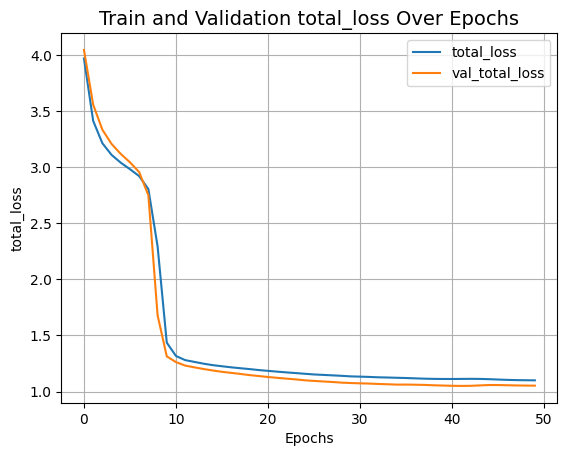

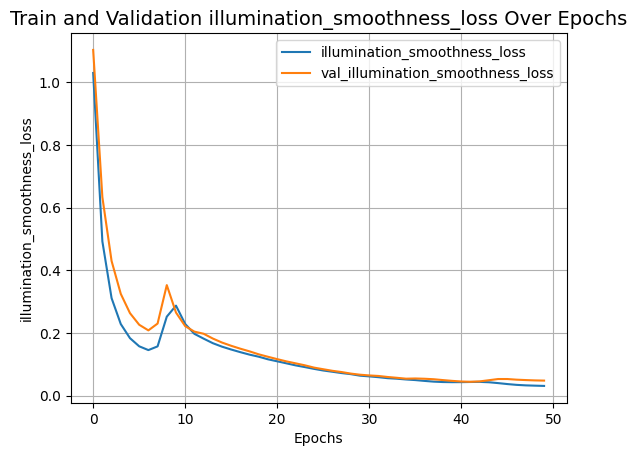

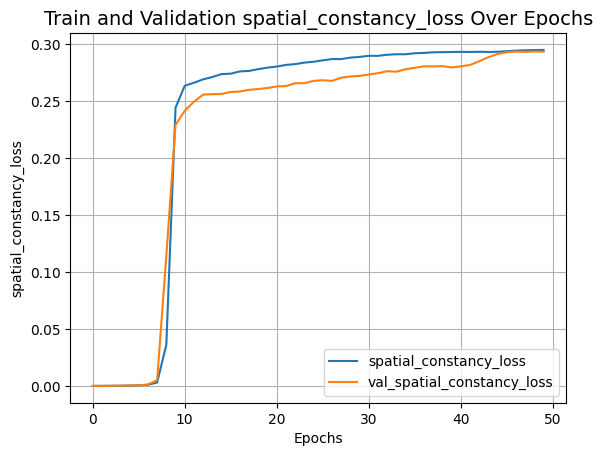

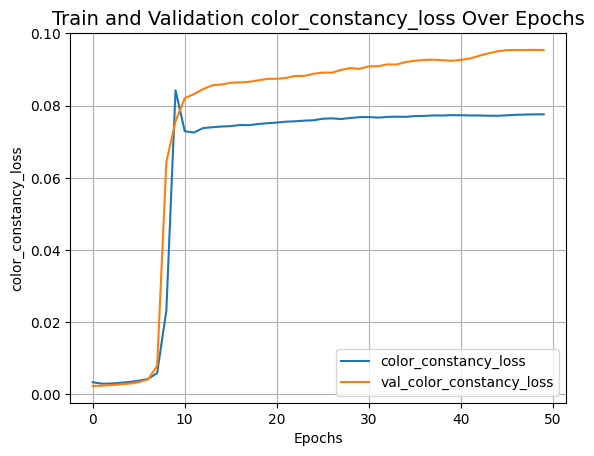

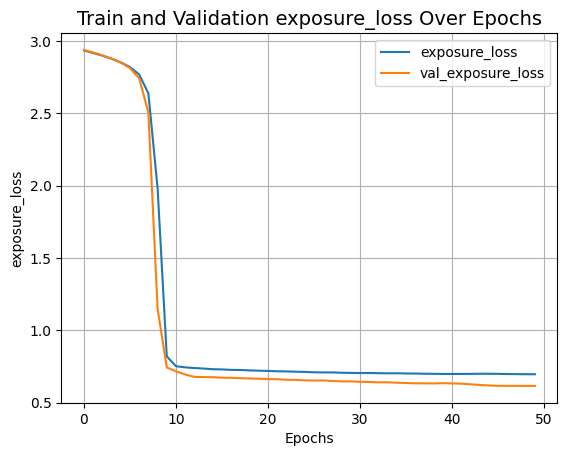

In [10]:
zero_dce_model = ZeroDCE()
zero_dce_model.compile(learning_rate=1e-4)
history = zero_dce_model.fit(train_dataset, validation_data=val_dataset, epochs=50)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("total_loss")
plot_result("illumination_smoothness_loss")
plot_result("spatial_constancy_loss")
plot_result("color_constancy_loss")
plot_result("exposure_loss")

In [1]:
def plot_results(images, titles, figure_size=(12, 12)):
    fig = plt.figure(figsize=figure_size)
    for i in range(len(images)):
        fig.add_subplot(1, len(images), i + 1).set_title(titles[i])
        _ = plt.imshow(images[i])
        plt.axis("off")
    plt.show()


def infer(original_image):
    image = keras.utils.img_to_array(original_image)
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)
    output_image = zero_dce_model(image)
    output_image = tf.cast((output_image[0, :, :, :] * 255), dtype=np.uint8)
    output_image = Image.fromarray(output_image.numpy())
    return output_image

In [18]:
import os
import numpy as np
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio
import glob

def infer(image):
    # Example enhancement - replace with actual enhancement logic
    # This is a placeholder, replace with real image processing
    return image

MAX_TRAIN_IMAGES = 100  # Set as needed
test_low_light_images = sorted(glob.glob("./lol_dataset/our485/low/*"))[:MAX_TRAIN_IMAGES]

psnr_scores = []
for val_image_file in test_low_light_images:
    try:
        # Open and process the image
        original_image = Image.open(val_image_file)
        enhanced_image = infer(original_image)
        
        # Convert images to numpy arrays
        gt_image = np.array(original_image)
        enhanced_image_np = np.array(enhanced_image)
        
        # Calculate MSE
        mse = np.mean((gt_image - enhanced_image_np) ** 2)
        
        print(f"Processing {val_image_file}")
        print(f"Original image min/max: {gt_image.min()}/{gt_image.max()}")
        print(f"Enhanced image min/max: {enhanced_image_np.min()}/{enhanced_image_np.max()}")
        print(f"MSE: {mse}")

        # Avoid division by zero in PSNR calculation
        if mse == 0:
            psnr = 99  # Set to a large value if MSE is zero
        else:
            psnr = peak_signal_noise_ratio(gt_image, enhanced_image_np)
        
        psnr_scores.append(psnr)
    except Exception as e:
        print(f"Error processing {val_image_file}: {e}")

if psnr_scores:
    average_psnr = np.mean(psnr_scores)
    print(f"Average PSNR on test set: {average_psnr} dB")
else:
    print("No PSNR values computed.")


Processing ./lol_dataset/our485/low\10.png
Original image min/max: 0/51
Enhanced image min/max: 0/51
MSE: 0.0
Processing ./lol_dataset/our485/low\100.png
Original image min/max: 0/86
Enhanced image min/max: 0/86
MSE: 0.0
Processing ./lol_dataset/our485/low\101.png
Original image min/max: 0/255
Enhanced image min/max: 0/255
MSE: 0.0
Processing ./lol_dataset/our485/low\102.png
Original image min/max: 0/255
Enhanced image min/max: 0/255
MSE: 0.0
Processing ./lol_dataset/our485/low\103.png
Original image min/max: 0/167
Enhanced image min/max: 0/167
MSE: 0.0
Processing ./lol_dataset/our485/low\104.png
Original image min/max: 0/164
Enhanced image min/max: 0/164
MSE: 0.0
Processing ./lol_dataset/our485/low\105.png
Original image min/max: 0/162
Enhanced image min/max: 0/162
MSE: 0.0
Processing ./lol_dataset/our485/low\106.png
Original image min/max: 0/114
Enhanced image min/max: 0/114
MSE: 0.0
Processing ./lol_dataset/our485/low\107.png
Original image min/max: 0/90
Enhanced image min/max: 0/90